> ## Visualizing and Transforming Data

Data visualization and transformation is an important part of every model. Now that we have our dataset downloaded, let's learn more about audio data visualization and transforming this dataset. We will be using ***tf.signal*** and ***tfio.audio*** processing operations to transform the data. Once we understand these concepts we will create our spectrogram images of the yes/no dataset to be used in the computer vision model.

>> ### Load the Dataset

Here we import the packages and create a ***load_audio*** and ***load_audio_files*** function to load audio files from a specified path into a dataset.

In [1]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import numpy as np
tf.multiply(2, 3)
ipd.clear_output()

In [2]:
def load_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split("_nohash_")
        utterance_number = int(utterance_number)
    
        # Load audio
        waveform, sample_rate = load_audio(file_path)
        dataset.append([waveform, sample_rate, label, speaker_id, utterance_number])
        
    return dataset

Call the `load_audio_files` function for each class we are going to use, then print the length of the dataset.

In [5]:
trainset_speechcommands_yes = load_audio_files('./data/mini_speech_commands/yes', 'yes')
trainset_speechcommands_no = load_audio_files('./data/mini_speech_commands/no', 'no')

print(f'Length of yes dataset: {len(trainset_speechcommands_yes)}')
print(f'Length of no dataset: {len(trainset_speechcommands_no)}')

Length of yes dataset: 1000
Length of no dataset: 1000


Now let's grab an example item from each dataset. We can see the waveform, sample_rate, label, and id.

In [6]:
yes_waveform = trainset_speechcommands_yes[0][0]
yes_sample_rate = trainset_speechcommands_yes[0][1]
print(f'Yes Waveform: {yes_waveform}')
print(f'Yes Sample Rate: {yes_sample_rate}')
print(f'Yes Label: {trainset_speechcommands_yes[0][2]}')
print(f'Yes ID: {trainset_speechcommands_yes[0][3]}')

no_waveform = trainset_speechcommands_no[0][0]
no_sample_rate = trainset_speechcommands_no[0][1]
print(f'No Waveform: {no_waveform}')
print(f'No Sample Rate: {no_sample_rate}')
print(f'No Label: {trainset_speechcommands_no[0][2]}')
print(f'No ID: {trainset_speechcommands_no[0][3]}')

Yes Waveform: [-0.0027771  -0.00537109 -0.00338745 ... -0.00112915 -0.00131226
 -0.00140381]
Yes Sample Rate: 16000
Yes Label: yes
Yes ID: 004ae714
No Waveform: [0.00720215 0.00610352 0.00552368 ... 0.00979614 0.0085144  0.00921631]
No Sample Rate: 16000
No Label: no
No ID: 012c8314


>> ### Transform and Visualize

Our data is ready! Let's breakdown some of the audio transforms and visualize them to better understand what they are and what they tell us about the data.

>>> #### Waveform

The waveform is generated by taking the sample rate and amplitude and representing the signal visually. This signal can be represented as a `waveform` which is the `signal` representation over time in a graphical format. The audio can be recorded in different `channels`. For example stereo recordings have 2 channels, right and left.

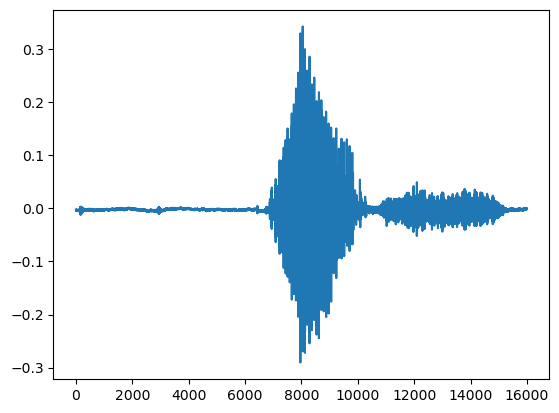

In [7]:
timescale = np.arange(yes_waveform.shape[0])
plt.figsize=(12, 8)
plt.plot(timescale, yes_waveform.numpy())
plt.show()

>>> #### Spectrogram

Next we will look at the `Spectrogram`. What is a spectrogram anyway?! A spectrogram allows you to visualize the amplitude as a function of frequency and time in the form of an image, where the 'x' axis represents time, the 'y' axis represents frequency, and the color represents the amplitude. This image is what we will use for our computer vision classification on our audio files.

Here we look at two different ways to create the spectrogram from the waveform. First we want to make our waveforms all equal lenths so we will pad them with zeros. Then we apply to transforms ***tf.signal.stft*** and ***tfio.audio.spectrogram***.

In [8]:
def get_spectrogram(waveform):
    
    frame_length = 255
    frame_step = 128
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length_waveform = tf.concat([waveform, zero_padding], 0)
    
    # Option 1: Use tfio to get the spectrogram
    spect = tfio.audio.spectrogram(input=equal_length_waveform, nfft=frame_length, window=frame_length, stride=frame_step)
    
    # Option 2: Use tf.signal processing to get the Short-time Fourier transform (stft)
    spectrogram = tf.signal.stft(equal_length_waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)

    return spectrogram, spect

## This funciton has some code from https://www.tensorflow.org/tutorials/audio/simple_audio

Lets listen to an example and then create a methond `plot_spectorgram` to display the two spectorgrams created.

In [9]:
spectrogram, spect = get_spectrogram(yes_waveform)

print('Label:', 'yes')
print('Waveform shape:', yes_waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Spect shape:', spect.shape)
print('Audio playback')
ipd.Audio(yes_waveform.numpy(), rate=16000)

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Spect shape: (125, 128)
Audio playback


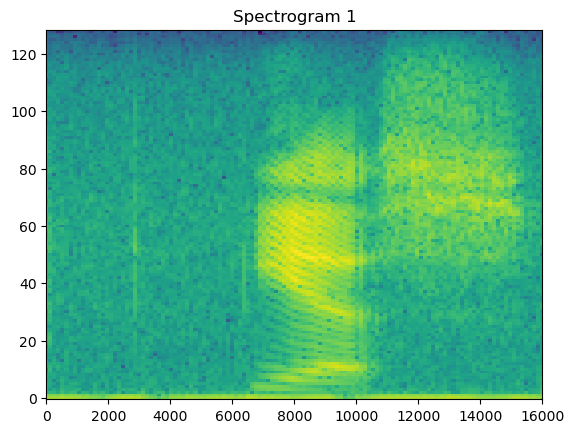

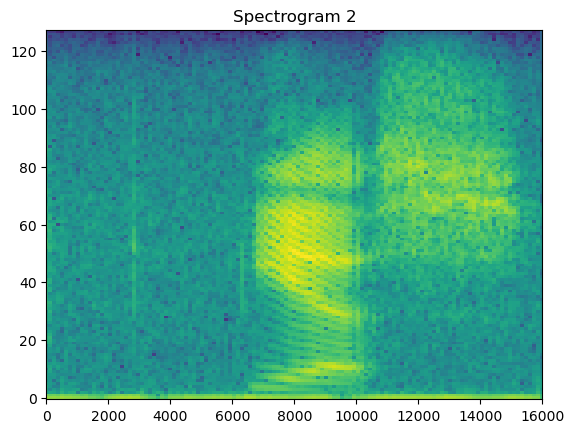

In [10]:
def plot_spectrogram(spectrogram, ax, title):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    ax.set_xlim([0, 16000])
    ax.set_title(title)
    
fig, ax = plt.subplots()  
plot_spectrogram(spectrogram.numpy(), ax, 'Spectrogram 1')
plt.show()

fig, ax = plt.subplots()  
plot_spectrogram(spect.numpy(), ax, 'Spectrogram 2')
plt.show()

>>> #### Save the spectrogram as an image

We have broken down some of the ways to understand our audio data and different transformations we can use on our data. Now lets create the images we will use for classification.

Below is a function to create the Spectrogram image for classification.

In [13]:
def create_images(dataset, label_dir):
    from tqdm import tqdm
    # make directory
    test_directory = f'./data/test/{label_dir}/'
    train_directory = f'./data/train/{label_dir}/'

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    os.makedirs(train_directory, mode=0o777, exist_ok=True)
    
    for i, data in tqdm(enumerate(dataset)):

        waveform = data[0]
        spectrogram, spect = get_spectrogram(waveform)

        # Split test and train images by 30%
        if i % 3 == 0:
            plt.imsave(f'./data/test/{label_dir}/spec_img{i}.png', spectrogram.numpy(), cmap='gray')
        else:
            plt.imsave(f'./data/train/{label_dir}/spec_img{i}.png', spectrogram.numpy(), cmap='gray')

        


In [14]:
create_images(trainset_speechcommands_yes, 'yes')
create_images(trainset_speechcommands_no, 'no')

1000it [00:11, 87.87it/s]
1000it [00:11, 90.45it/s]


We now have our audio as spectrogram images and are ready to build the model!